<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 7

## NLP and Machine Learning on [travel.statsexchange.com](http://travel.stackexchange.com/) data

---

In Project 7 you'll be doing NLP and machine learning on post data from stackexchange's travel subdomain. 

This project is setup like a mini Kaggle competition. You are given the training data and when projects are submitted your model will be tested on the held-out testing data. There will be prizes for the people who build models that perform best on the held out test set!

---

## Notes on the data

The data is again compressed into the `.7z` file format to save space. There are 6 .csv files and one readme file that contains some information on the fields.

    posts_train.csv
    comments_train.csv
    users.csv
    badges.csv
    votes_train.csv
    tags.csv
    readme.txt
    
The data is located in your datasets folder:

    DSI-SF-2/datasets/stack_exchange_travel.7z
    
If you're interested in where this data came from and where to get more data from other stackexchange subdomains, see here:

https://ia800500.us.archive.org/22/items/stackexchange/readme.txt


### Recommended Utilities for .7z

- For OSX [Keka](http://www.kekaosx.com/en/) or [The Unarchiver](http://wakaba.c3.cx/s/apps/unarchiver.html). 
- For Windows [7-zip](http://www.7-zip.org/) is the standard. 
- For Linux try the `p7zip` utility.  `sudo apt-get install p7zip`.



In [1]:
#Import packages and librarys
import pandas as pd
import numpy as np
import patsy
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict, train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.grid_search import GridSearchCV
import seaborn as sns
from gensim import corpora, models, matutils
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
posts_train = pd.read_csv('/Users/nsivapra/Desktop/DSI-SF-2-nsivapra/project7/stack_exchange_travel/posts_train.csv')
comments_train = pd.read_csv('/Users/nsivapra/Desktop/DSI-SF-2-nsivapra/project7/stack_exchange_travel/comments_train.csv')
users = pd.read_csv('/Users/nsivapra/Desktop/DSI-SF-2-nsivapra/project7/stack_exchange_travel/users.csv')
badges = pd.read_csv('/Users/nsivapra/Desktop/DSI-SF-2-nsivapra/project7/stack_exchange_travel/badges.csv')
votes_train = pd.read_csv('/Users/nsivapra/Desktop/DSI-SF-2-nsivapra/project7/stack_exchange_travel/votes_train.csv')
tags = pd.read_csv('/Users/nsivapra/Desktop/DSI-SF-2-nsivapra/project7/stack_exchange_travel/tags.csv')

In [3]:
#Renaming some columns to meaningful names
posts_train.rename(columns={'Score': 'PostScore'}, inplace=True)
comments_train.rename(columns = {'Score': 'CommentScore'}, inplace=True)

#Merging the posts table with the comments table and then the users table.
posts_comments = pd.merge(posts_train, comments_train, how='inner', left_on=['Id'], right_on=['PostId'])
posts_merged = pd.merge(posts_comments, users, how='inner', left_on=['UserId'], right_on=['Id'])

In [4]:
posts_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41289 entries, 0 to 41288
Data columns (total 21 columns):
AcceptedAnswerId         6516 non-null float64
AnswerCount              13988 non-null float64
Body                     40476 non-null object
ClosedDate               2627 non-null object
CommentCount             41289 non-null int64
CommunityOwnedDate       181 non-null object
CreationDate             41289 non-null object
FavoriteCount            3522 non-null float64
Id                       41289 non-null int64
LastActivityDate         41289 non-null object
LastEditDate             23363 non-null object
LastEditorDisplayName    844 non-null object
LastEditorUserId         22883 non-null float64
OwnerDisplayName         1173 non-null object
OwnerUserId              40552 non-null float64
ParentId                 23967 non-null float64
PostTypeId               41289 non-null int64
PostScore                41289 non-null int64
Tags                     13988 non-null object
Titl

In [5]:
posts_train['ClosedDate'] = pd.to_datetime(pd.Series(posts_train['ClosedDate']))
posts_train['CommunityOwnedDate'] = pd.to_datetime(pd.Series(posts_train['CommunityOwnedDate']))
posts_train['CreationDate'] = pd.to_datetime(pd.Series(posts_train['CreationDate']))
posts_train['LastActivityDate'] = pd.to_datetime(pd.Series(posts_train['LastActivityDate']))
posts_train['LastEditDate'] = pd.to_datetime(pd.Series(posts_train['LastEditDate']))

In [6]:
comments_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81506 entries, 0 to 81505
Data columns (total 7 columns):
CreationDate       81506 non-null object
Id                 81506 non-null int64
PostId             81506 non-null int64
CommentScore       81506 non-null int64
Text               81506 non-null object
UserDisplayName    1801 non-null object
UserId             80425 non-null float64
dtypes: float64(1), int64(3), object(3)
memory usage: 4.4+ MB


In [7]:
comments_train['CreationDate'] = pd.to_datetime(pd.Series(comments_train['CreationDate']))

In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29283 entries, 0 to 29282
Data columns (total 14 columns):
AboutMe            10215 non-null object
AccountId          29283 non-null int64
Age                8414 non-null float64
CreationDate       29283 non-null object
DisplayName        29282 non-null object
DownVotes          29283 non-null int64
Id                 29283 non-null int64
LastAccessDate     29283 non-null object
Location           11475 non-null object
ProfileImageUrl    16853 non-null object
Reputation         29283 non-null int64
UpVotes            29283 non-null int64
Views              29283 non-null int64
WebsiteUrl         7900 non-null object
dtypes: float64(1), int64(6), object(7)
memory usage: 3.1+ MB


In [9]:
users['CreationDate'] = pd.to_datetime(pd.Series(users['CreationDate']))
users['LastAccessDate'] = pd.to_datetime(pd.Series(users['LastAccessDate']))

In [10]:
badges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71246 entries, 0 to 71245
Data columns (total 6 columns):
Class       71246 non-null int64
Date        71246 non-null object
Id          71246 non-null int64
Name        71246 non-null object
TagBased    71246 non-null bool
UserId      71246 non-null int64
dtypes: bool(1), int64(3), object(2)
memory usage: 2.8+ MB


In [11]:
badges['Date'] = pd.to_datetime(pd.Series(badges['Date']))

In [12]:
votes_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289553 entries, 0 to 289552
Data columns (total 6 columns):
BountyAmount    1211 non-null float64
CreationDate    289553 non-null object
Id              289553 non-null int64
PostId          289553 non-null int64
UserId          7484 non-null float64
VoteTypeId      289553 non-null int64
dtypes: float64(2), int64(3), object(1)
memory usage: 13.3+ MB


In [13]:
votes_train['CreationDate'] = pd.to_datetime(pd.Series(votes_train['CreationDate']))

In [14]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 5 columns):
Count            1606 non-null int64
ExcerptPostId    1390 non-null float64
Id               1606 non-null int64
TagName          1606 non-null object
WikiPostId       1390 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 62.8+ KB


In [15]:
posts_train.head()

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,LastEditorDisplayName,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,PostScore,Tags,Title,ViewCount
0,393.0,4.0,<p>My fiancée and I are looking for a good Car...,2013-02-25 23:52:47.953,4,NaT,2011-06-21 20:19:34.730,NaN,1,2012-05-24 14:52:14.760,...,NaN,101.0,NaN,9.0,NaN,1,8,<caribbean><cruising><vacations>,What are some Caribbean cruises for October?,361.0
1,NaN,1.0,<p>Singapore Airlines has an all-business clas...,NaT,1,NaT,2011-06-21 20:24:57.160,NaN,4,2013-01-09 09:55:22.743,...,NaN,693.0,NaN,24.0,NaN,1,8,<loyalty-programs><routes><ewr><singapore-airl...,Does Singapore Airlines offer any reward seats...,219.0
2,770.0,5.0,<p>Another definition question that interested...,NaT,0,NaT,2011-06-21 20:25:56.787,2.0,5,2012-10-12 20:49:08.110,...,NaN,101.0,NaN,13.0,NaN,1,11,<romania><transportation>,What is the easiest transportation to use thro...,340.0
3,62.0,3.0,<p>Can anyone suggest the best way to get from...,NaT,2,NaT,2011-06-21 20:30:38.687,1.0,8,2016-03-28 03:41:28.130,...,user141,NaN,NaN,26.0,NaN,1,11,<usa><airport-transfer><taxis><seattle>,Best way to get from SeaTac airport to Redmond?,9219.0
4,178.0,4.0,<p>We are considering visiting Argentina for u...,2016-01-02 10:26:48.277,1,NaT,2011-06-21 20:31:21.800,8.0,9,2016-01-01 21:58:02.303,...,NaN,101.0,NaN,23.0,NaN,1,12,<sightseeing><public-transport><transportation...,What are must-visit destinations for the first...,1503.0


In [16]:
comments_train.head()

,CreationDate,Id,PostId,CommentScore,Text,UserDisplayName,UserId
0,2011-06-21 20:25:14.257,1,1,0,To help with the cruise line question: Where a...,NaN,12.0
1,2011-06-21 20:27:35.300,2,1,0,"Toronto, Ontario. We can fly out of anywhere t...",NaN,9.0
2,2011-06-21 20:32:23.687,3,1,3,"""Best"" for what? Please read [this page](http...",NaN,20.0
3,2011-06-21 20:42:08.330,9,25,0,"Are you in the UK? If so, would be helpful to ...",NaN,30.0
4,2011-06-21 20:44:09.990,12,26,3,"Where are you starting from, and what sort of ...",NaN,26.0


In [17]:
users.head()

,AboutMe,AccountId,Age,CreationDate,DisplayName,DownVotes,Id,LastAccessDate,Location,ProfileImageUrl,Reputation,UpVotes,Views,WebsiteUrl
0,"<p>Hi, I'm not really a person.</p>\n\n<p>I'm ...",-1,NaN,2011-06-21 15:16:44.253,Community,8492,-1,2011-06-21 15:16:44.253,on the server farm,NaN,1,2463,0,http://meta.stackexchange.com/
1,<p>Developer on the Stack Overflow team. Find...,2,39.0,2011-06-21 20:10:03.720,Geoff Dalgas,0,2,2016-05-29 01:18:20.767,"Corvallis, OR",NaN,101,1,29,http://stackoverflow.com
2,"<p><a href=""http://blog.stackoverflow.com/2011...",7598,31.0,2011-06-21 20:11:02.490,Nick Craver,0,3,2015-09-14 12:03:40.247,"Winston-Salem, NC",https://i.stack.imgur.com/nGCYr.jpg,101,1,13,http://nickcraver.com/blog/
3,"<p>co-founder of <a href=""https://airtable.com...",1998,30.0,2011-06-21 20:12:21.223,Emmett,0,4,2013-03-01 22:30:26.790,"San Francisco, CA",https://i.stack.imgur.com/d1oHX.jpg?s=128&g=1,101,1,9,http://minesweeperonline.com
4,"<p><a href=""http://blog.stackoverflow.com/2010...",29738,NaN,2011-06-21 20:15:31.410,Kevin Montrose,0,5,2015-11-14 20:29:43.917,"New York, NY, United States",NaN,101,0,6,http://kevinmontrose.com/


In [18]:
badges.head()

,Class,Date,Id,Name,TagBased,UserId
0,3,2011-06-21 20:16:48.910,1,Autobiographer,False,2
1,3,2011-06-21 20:16:48.910,2,Autobiographer,False,3
2,3,2011-06-21 20:16:48.910,3,Autobiographer,False,4
3,3,2011-06-21 20:21:49.157,4,Autobiographer,False,6
4,3,2011-06-21 20:21:49.157,5,Autobiographer,False,8


In [19]:
votes_train.head()

,BountyAmount,CreationDate,Id,PostId,UserId,VoteTypeId
0,NaN,2011-06-21,1,1,NaN,2
1,NaN,2011-06-21,2,1,NaN,2
2,NaN,2011-06-21,5,5,13.0,5
3,NaN,2011-06-21,7,7,NaN,2
4,NaN,2011-06-21,9,1,NaN,2


In [20]:
tags.head()

,Count,ExcerptPostId,Id,TagName,WikiPostId
0,75,2138.0,1,cruising,2137.0
1,39,357.0,2,caribbean,356.0
2,31,319.0,4,vacations,318.0
3,6,14548.0,6,amazon-river,14547.0
4,74,1792.0,8,romania,1791.0


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 1. Use LDA to find what topics are discussed on travel.stackexchange.com.

---

Text can be found in the posts and the comments datasets. The `ParentId` column in the posts dataset indicates what the "question" post was for a given post. Comment text can be merged onto the post they are part of with the `PostId` field.

The text may have some HTML tags. BeautifulSoup has convenient ways to get rid of markup or extract text if you need to. You can also parse the strings yourself if you like.

The tags dataset has the "tags" that the users have officially given the post.

**1.1 Implement LDA against the text features of the dataset(s).**

- This can be posts or a combination of posts and comments if you want more power.
- Find optimal **K/num_topics**.

**1.2 Compare your topics to the tags. Do the LDA topics make sense? How do they compare to the tags?**


In [21]:
posts_train.Body = posts_train.Body.replace(np.nan,' ', regex=True) #Replace nan with empty space

#Clean the dataframe column by removing the html tags.
import re
listVal = []
i = 0
while i < len(posts_train['Body']):
    listVal.append(posts_train['Body'][i])
    i+=1

newList = []
for a in listVal:
    newList.append(re.sub('<[^<]+?>', '', str(a)))
posts_train['Body'] = newList

posts_train['Body'] = posts_train['Body'].str.replace('\n', '')
#-----------
posts_train['Title'] = posts_train['Title'].replace(np.nan,' ', regex=True)
comments_train['Text'] = comments_train['Text'].replace(np.nan,' ', regex=True)

In [22]:
cv = CountVectorizer(ngram_range=(1,2), max_features=2500, binary=True, stop_words='english')
words_title = cv.fit_transform(posts_train['Title'])
words_body = cv.fit_transform(posts_train['Body'])
words_text = cv.fit_transform(comments_train['Text'])

In [23]:
title_df = pd.DataFrame(words_title.todense(), columns=cv.get_feature_names())
body_df = pd.DataFrame(words_body.todense(), columns=cv.get_feature_names())
text_df = pd.DataFrame(words_text.todense(), columns=cv.get_feature_names())

In [24]:
print title_df.youtube.values.sum()
print body_df.youtube.values.sum()
print text_df.youtube.values.sum()

48
1993
150


In [25]:
vocab = {v: k for k, v in cv.vocabulary_.iteritems()}
vocab

{0: u'00',
 1: u'000',
 2: u'01',
 3: u'10',
 4: u'10 years',
 5: u'100',
 6: u'1000',
 7: u'11',
 8: u'12',
 9: u'13',
 10: u'14',
 11: u'15',
 12: u'150',
 13: u'16',
 14: u'17',
 15: u'18',
 16: u'180',
 17: u'19',
 18: u'1st',
 19: u'20',
 20: u'200',
 21: u'2000',
 22: u'2010',
 23: u'2011',
 24: u'2012',
 25: u'2013',
 26: u'2014',
 27: u'2015',
 28: u'2016',
 29: u'21',
 30: u'22',
 31: u'23',
 32: u'24',
 33: u'24 hours',
 34: u'25',
 35: u'29',
 36: u'2nd',
 37: u'30',
 38: u'30 days',
 39: u'300',
 40: u'35',
 41: u'3rd',
 42: u'40',
 43: u'45',
 44: u'50',
 45: u'500',
 46: u'60',
 47: u'70',
 48: u'75',
 49: u'80',
 50: u'90',
 51: u'90 180',
 52: u'90 day',
 53: u'90 days',
 54: u'94',
 55: u'aa',
 56: u'ability',
 57: u'able',
 58: u'abroad',
 59: u'absolutely',
 60: u'accept',
 61: u'acceptable',
 62: u'accepted',
 63: u'accepting',
 64: u'access',
 65: u'accessible',
 66: u'accident',
 67: u'accommodation',
 68: u'according',
 69: u'accordingly',
 70: u'account',
 71: u

In [26]:
lda_title = models.LdaModel(
    matutils.Sparse2Corpus(words_title, documents_columns=False),
    num_topics  =  3,
    passes      =  1,
    id2word     =  vocab
)

In [27]:
lda_body = models.LdaModel(
    matutils.Sparse2Corpus(words_body, documents_columns=False),
    num_topics  =  3,
    passes      =  1,
    id2word     =  vocab
)

In [28]:
lda_text = models.LdaModel(
    matutils.Sparse2Corpus(words_text, documents_columns=False),
    num_topics  =  3,
    passes      =  1,
    id2word     =  vocab
)

In [29]:
print lda_title.print_topics(num_topics=3, num_words=5)
print"\n"
print lda_body.print_topics(num_topics=3, num_words=5)
print"\n"
print lda_text.print_topics(num_topics=3, num_words=5)
print"\n"

[(0, u'0.037*returning + 0.035*updated + 0.028*test + 0.023*rights + 0.021*fast'), (1, u'0.080*updated + 0.040*training + 0.022*telling + 0.017*misleading + 0.015*temporary'), (2, u'0.020*study + 0.019*direct + 0.019*advantage + 0.015*careful + 0.011*chose')]


[(0, u'0.008*large + 0.007*ireland + 0.007*ticket + 0.006*parking + 0.006*drink'), (1, u'0.019*vienna + 0.009*month + 0.009*oyster + 0.008*crossed + 0.008*translation'), (2, u'0.011*flight + 0.009*america + 0.007*thinking + 0.006*clarify + 0.006*ticket')]


[(0, u'0.012*just + 0.010*don + 0.009*time + 0.007*like + 0.007*flight'), (1, u'0.026*visa + 0.024*question + 0.022*travel + 0.012*questions + 0.011*stackexchange'), (2, u'0.025*answer + 0.019*www + 0.017*thanks + 0.017*http + 0.014*com')]




In [30]:
posts_train[['Tags']]

,Tags
0,<caribbean><cruising><vacations>
1,<loyalty-programs><routes><ewr><singapore-airl...
2,<romania><transportation>
3,<usa><airport-transfer><taxis><seattle>
4,<sightseeing><public-transport><transportation...
5,<russia><visas><china><mongolia><trans-siberian>
6,<online-resources><transportation><peru><south...
7,<us-citizens><travel-agents><cuba>
8,<europe><online-resources><planning><guides><t...
9,NaN


In [31]:
# A realistic KNum/topics value would be around 10 to prevent outliers in the weightage of the words.
#A number too low allows for outliers and a high value will cause the weightage to be around 0.01
#Comparing the tags to the topics there are some values that are similar and there are some occasional
#tags that don't match with the estimated topics. In general the tags are helpful in finding the topic
#of the post.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 2. What makes an answer likely to be "accepted"?

---

**2.1 Build a model to predict whether a post will be marked as the answer.**

- This is a classification problem.
- You're free to use any of the machine learning algorithms or techniques we have learned in class to build the best model you can.
- NLP will be very useful here for pulling out useful and relevant features from the data. 
- Though not required, using bagging and boosting models like Random Forests and Gradient Boosted Trees will _probably_ get you the highest performance on the test data (but who knows!).


**2.2 Evaluate the performance of your classifier with a confusion matrix and accuracy. Explain how your model is performing.**

**2.3 Plot either a ROC curve or precision-recall curve (or both!) and explain what they tell you about your model.**

NOTE: You should only be predicting this for `PostTypeID=2` posts, which are the "answer" posts. This doesn't mean, however, that you can't or shouldn't use the parent questions as predictors!


In [32]:
#Count Vectorizing the merged dataframe
cv = CountVectorizer(ngram_range=(1,2), max_features=2500, binary=True, stop_words='english')
text = cv.fit_transform(posts_merged['Text'])
body = cv.fit_transform(posts_merged['Body'])

text_merged = pd.DataFrame(text.todense(), columns=cv.get_feature_names())

In [33]:
posts_merged['PostTypeId'] = posts_merged['PostTypeId'].map(lambda x: 1 if x > 1 else 0) #Answer vs Non Answer Post

In [34]:
X = text_merged.values
y = posts_merged.PostTypeId

In [35]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5)
lr = LogisticRegression()
lr.fit(Xtrain, ytrain)

gb_scores = cross_val_score(lr, Xtest, ytest, cv=5)

print "R^2:", np.mean(gb_scores)

R^2: 0.630069899409


In [36]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

def plot_roc(mod, X, y, varname):
    mod.fit(X, y)
    y_pp = mod.predict_proba(X)[:, 1]
    fpr_, tpr_, _ = roc_curve(y, y_pp)
    auc_ = auc(fpr_, tpr_)
    acc_ = np.abs(0.5 - np.mean(y)) + 0.5
    
    fig, axr = plt.subplots(figsize=(8,7))

    axr.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_,
             color='darkred', linewidth=4,
             alpha=0.7)
    axr.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)

    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('false positive rate', fontsize=16)
    axr.set_ylabel('true positive rate', fontsize=16)
    axr.set_title(varname+' vs. not ROC curve\n', fontsize=20)

    axr.legend(loc="lower right", fontsize=12)

    plt.show()

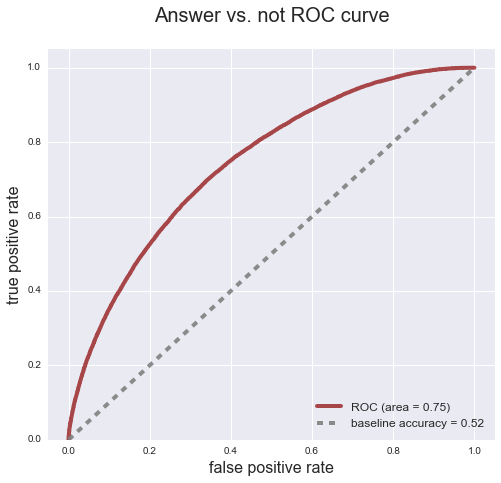

In [37]:
plot_roc(lr, X, y, 'Answer')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 3. What is the score of a post?

---

**3.1 Build a model that predicts the score of a post.**

- This is a regression problem now. 
- You can and should be predicting score for both "question" and "answer" posts, so keep them both in your dataset.
- Again, use any techniques that you think will get you the best model.

**3.2 Evaluate the performance of your model with cross-validation and report the results.**

**3.3 What is important for determining the score of a post, if anything?**


In [38]:
filter_df = posts_merged.filter(regex = 'Count|UpVotes|Reputation|Views|PostScore|AcceptedAns|PostType')
count = posts_merged.filter(regex = 'PostScore')
col = filter_df.columns - count.columns

filter_df = filter_df.fillna(filter_df.mean())

X = filter_df[col]
y = filter_df['PostScore'].values

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  app.launch_new_instance()


In [39]:
gb = GradientBoostingRegressor()
gb.fit(X, y)

gb_scores = cross_val_score(gb, X, y, cv=5)

print "R^2:", np.mean(gb_scores)

R^2: 0.51817316593


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 4. How many views does a post have?

---

**4.1 Build a model that predicts the number of views a post has.**

- This is another regression problem. 
- Predict the views for all posts, not just the "answer" posts.

**4.2 Evaluate the performance of your model with cross-validation and report the results.**

**4.3 What is important for the number of views a post has, if anything?**

In [40]:
filter_df = posts_merged.filter(regex = 'Count|Score|Views|Up|Reputation|PostType|AcceptedAnswer')
count = posts_merged.filter(regex = 'ViewCount')
col = filter_df.columns - count.columns

filter_df = filter_df.fillna(filter_df.mean())

X = filter_df[col]
y = filter_df['ViewCount'].values

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  app.launch_new_instance()


In [41]:
# gb = RandomForestRegressor(n_estimators=100)
gb = ExtraTreesRegressor()
gb.fit(X, y)

gb_scores = cross_val_score(gb, X, y, cv=5)

print "R^2:", np.mean(gb_scores)

R^2: 0.716146356775


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5. Build a pipeline or other code to automate evaluation of your models on the test data.

---

Now that you've constructed your three predictive models, build a pipeline or code that can easily load up the raw testing data and evaluate your models on it.

The testing data that is held out is in the same raw format as the training data you have. _Any cleaning and preprocessing that you did on the training data will need to be done on the testing data as well!_

This is a good opportunity to practice building pipelines, but you're not required to. Custom functions and classes are fine as long as they are able to process and test the new data.


In [42]:
def clean_dataframe(posts_train, comments_train, users, badges, votes_train):
    posts_train['ClosedDate'] = pd.to_datetime(pd.Series(posts_train['ClosedDate']))
    posts_train['CommunityOwnedDate'] = pd.to_datetime(pd.Series(posts_train['CommunityOwnedDate']))
    posts_train['CreationDate'] = pd.to_datetime(pd.Series(posts_train['CreationDate']))
    posts_train['LastActivityDate'] = pd.to_datetime(pd.Series(posts_train['LastActivityDate']))
    posts_train['LastEditDate'] = pd.to_datetime(pd.Series(posts_train['LastEditDate']))
    #Renaming some columns to meaningful names
    comments_train['CreationDate'] = pd.to_datetime(pd.Series(comments_train['CreationDate']))
    users['CreationDate'] = pd.to_datetime(pd.Series(users['CreationDate']))
    users['LastAccessDate'] = pd.to_datetime(pd.Series(users['LastAccessDate']))
    badges['Date'] = pd.to_datetime(pd.Series(badges['Date']))
    votes_train['CreationDate'] = pd.to_datetime(pd.Series(votes_train['CreationDate']))
    posts_train.rename(columns={'Score': 'PostScore'}, inplace=True)
    comments_train.rename(columns = {'Score': 'CommentScore'}, inplace=True)

    #Merging the posts table with the comments table and then the users table.
    posts_comments = pd.merge(posts_train, comments_train, how='inner', left_on=['Id'], right_on=['PostId'])
    posts_merged = pd.merge(posts_comments, users, how='inner', left_on=['UserId'], right_on=['Id'])
    posts_merged['PostTypeId'] = posts_merged['PostTypeId'].map(lambda x: 1 if x > 1 else 0)

    return posts_merged
train_df = clean_dataframe(posts_train, comments_train, users, badges, votes_train)

In [43]:
def classifier(posts_merged):
    cv = CountVectorizer(ngram_range=(1,2), max_features=2500, binary=True, stop_words='english')
    text = cv.fit_transform(posts_merged['Text'])
    body = cv.fit_transform(posts_merged['Body'])

    text_merged = pd.DataFrame(text.todense(), columns=cv.get_feature_names())
    X = text_merged.values
    y = posts_merged['PostTypeId']
#     return X, y

# def classifier_score(train):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5)
    lr = LogisticRegression()
    lr.fit(Xtrain, ytrain)

    gb_scores = cross_val_score(lr, Xtest, ytest, cv=5)

    print "R^2:", np.mean(gb_scores)
    return plot_roc(lr, Xtest, ytest, 'Answer')

R^2: 0.634993494152


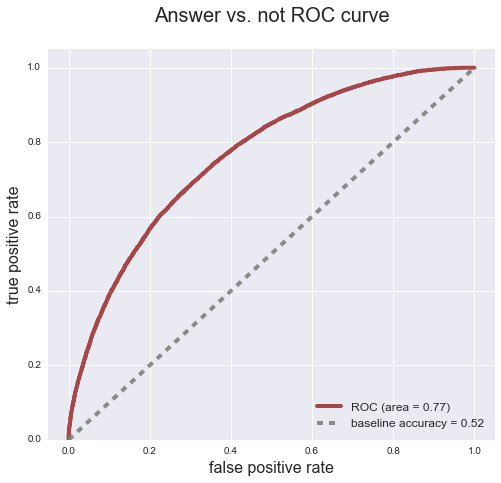

In [44]:
classifier(train_df)

In [45]:
def regressor(posts_merged):
    filter_df = posts_merged.filter(regex = 'Count|UpVotes|Reputation|Views|Score|AcceptedAns|PostType|Id')
    count = posts_merged.filter(regex = 'PostScore')
    col = filter_df.columns - count.columns

    filter_df = filter_df.fillna(filter_df.mean())

    
    X = filter_df[col]
    y = filter_df['PostScore'].values
    
    return X, y

def regressor_score(train):
    gb = RandomForestRegressor()
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5)

    gb.fit(Xtrain, ytrain)

    gb_scores = cross_val_score(gb, Xtest, ytest, cv=5)

    print "R^2:", np.mean(gb_scores)

In [46]:
regressor_score(train_df)

R^2: 0.540815913559


In [47]:
def regressor_2(posts_merged):
    filter_df = posts_merged.filter(regex = 'Count|Score|Views|Up|Reputation|PostType|AcceptedAnswer')
    count = posts_merged.filter(regex = 'ViewCount')
    col = filter_df.columns - count.columns

    filter_df = filter_df.fillna(filter_df.mean())

    X2 = filter_df[col]
    y2 = filter_df['ViewCount'].values
#     return X2,y2

# def regressor_view(train):
#     Xtrain, ytrain = regressor_2(train)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X2, y2, test_size=0.5)
    gb = ExtraTreesRegressor()
    gb.fit(Xtrain, ytrain)

    gb_scores = cross_val_score(gb, Xtest, ytest, cv=5)

    print "R^2:", np.mean(gb_scores)

In [48]:
regressor_2(train_df)

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()


R^2: 0.661938081559
